In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pickle
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from copy import deepcopy 

from IPython import display

import matplotlib as mpl
import matplotlib.pyplot as plt



#import time
np.set_printoptions(precision=3, suppress=True)

In [3]:
#from ipynb.fs.full.dataset import generate_offset_snapshot_list, \
#        get_snapshot_label_and_weight_list, \
#        remove_outliers, \
#        normalize_snapshots, \
#        shuffled_train_test_split, \
#        generate_ds, \
#        show_batch

In [ ]:
# additional section can be used for generation of present/future pairs
def generate_offset_snapshot_list(trajectory_list, offset):
    # if this function is called with offset 0, present and future trajectory list are the same
    # as the trajectory_list and are therefore returned like this without any calculation
    if offset == 0:
        return trajectory_list, trajectory_list
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
    past_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
    trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
    return past_trajectory_list, trajectory_list

def get_snapshot_label_and_weight_list(trajectory_list, trajectory_label_list, offset = 0, progress_label = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    snapshot_weight_list = []
#    len_AA = sum([1 for x in trajectory_label_list if x == 0.0])
#    len_AB = sum([1 for x in trajectory_label_list if x == 0.5])
#    len_BB = len(trajectory_label_list) - len_AA - len_AB
    len_AA = sum([len(trajectory_list[x]) for x in range(len(trajectory_label_list)) \
                  if trajectory_label_list[x] == -1.0])
    len_AB = sum([len(trajectory_list[x]) for x in range(len(trajectory_label_list)) \
                  if trajectory_label_list[x] == -0.5])
    len_BA = sum([len(trajectory_list[x]) for x in range(len(trajectory_label_list)) \
                  if trajectory_label_list[x] == 0.5])
    len_BB = sum([len(trajectory_list[x]) for x in range(len(trajectory_label_list)) \
                  if trajectory_label_list[x] == 1.0])
    if ONLY_TRANSITION:
        len_all_paths = len_AB + len_BA
    else:
        len_all_paths = len_AA + len_AB + len_BA + len_BB
    """JUST for testing"""
#    len_all_paths = 1 
    reciprocal_len_AA = 1.0/len_AA*len_all_paths
    reciprocal_len_AB = 1.0/len_AB*len_all_paths
    reciprocal_len_BA = 1.0/len_BA*len_all_paths
    reciprocal_len_BB = 1.0/len_BB*len_all_paths
    print(len_AA, len_AB, len_BA, len_BB)
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            """
            Assigns the label and weight for each of the snapshots.
            For AA and BB paths the label is set to 0 or 1 respectively, 
            and the weight set to the corresponding value for this type of path.
            If it is a transition path the corresponding weight is assigned to the snapshot,
            and depending on whether progress_label is true or not either the label copied
            or recalculated based on how far the path has gotten.
            """
            # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
            # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
            # indicating a sucessfull transition a progress along the snapshots is calculated based on
            # the position within the trajectory and the total trajectory length.
            # For present/future lists, the offset needs to be taken into account in the denominator
            # If the dataset is a future variant of an offset trajectory list the progress label 
            # needs to additionally take the offset into account in the nominator.
            if ONLY_TRANSITION == False:
                if trajectory_label == -1.0:
                    snapshot_list.append(trajectory[snapshot_nr])                
                    snapshot_weight_list.append(reciprocal_len_AA*LABEL_AA_weight_factor)
                    snapshot_label_list.append(-1.0)
    #                snapshot_label_list.append(trajectory_label)
                elif trajectory_label == 1.0:
                    snapshot_list.append(trajectory[snapshot_nr])        
                    snapshot_weight_list.append(reciprocal_len_BB*LABEL_BB_weight_factor)
                    snapshot_label_list.append(1.0)
            if trajectory_label != -1.0 and trajectory_label != 1.0:
                snapshot_list.append(trajectory[snapshot_nr])
#                snapshot_weight_list.append(reciprocal_len_AB*LABEL_AB_weight_factor \
#                                          + reciprocal_len_BA*LABEL_BA_weight_factor)
                # leaving out "Future == True" from prior versions of the code
                # means that the snapshot_label_list of the past version will be incorrect
                # since it is not used, however, this should not pose a problem

                # if the path is an AB path, the progress label counts upwards
                # if it is a BA path it counts down
                if trajectory_label == -0.5:
                    snapshot_weight_list.append(reciprocal_len_AB*LABEL_AB_weight_factor)
                    if progress_label == False:
                        snapshot_label_list.append(0.0)
                    else:
                        snapshot_label_list.append((2*(snapshot_nr + offset)\
                                    /(len(trajectory) - 1.0 + offset))-1)
                        #print(trajectory_label, snapshot_label_list[-1], snapshot_list[-1][:2])
                elif trajectory_label == 0.5:
                    snapshot_weight_list.append(reciprocal_len_BA*LABEL_BA_weight_factor)
                    if progress_label == False:
                        snapshot_label_list.append(0.0)
                    else:
                        snapshot_label_list.append((2*(len(trajectory)\
                                    -(snapshot_nr + offset + 1))/(len(trajectory) + offset - 1))-1)
                        #print(trajectory_label, snapshot_label_list[-1], snapshot_list[-1][:2])
                #print(snapshot_weight_list[-1])
    return np.array(snapshot_list), np.array(snapshot_label_list), np.array(snapshot_weight_list)

def show_batch(dataset):
    for batch, label, weights in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))
            
def remove_outliers(snapshot_list, lower_bound, upper_bound):
    """Sets the values of a snapshopt that lie outside of the bounds to that 
    bound while leaving the other values unchanged.
    Initially transposes the snapshot_list to a column list
    For each column, it iterates over all entries and compares them to the 
    lower or upper bound of that column. If they are lower or higher, they are changed to
    the value of that bound.
    Returns the transpose of the column list, thereby giving the cleaned snapshot_list.
    """
    
    column_list = np.transpose(snapshot_list)
    column_list = [[min(upper_bound[col_nr],max(lower_bound[col_nr],entry)) \
                                for entry in column_list[col_nr]] \
                                for col_nr in range(len(lower_bound))]
    return np.transpose(column_list)

In [54]:


def normalize_snapshots(snapshot_list, mean, std):
    """Normalizes the snapshot_list by substracting the mean and dividing by the standard deviation."""
    return (snapshot_list - mean)/std

def shuffled_train_test_split(trajectory_list, trajectory_label_list, split_ratio, offset = 0, progress_label = False):
    assert isinstance(split_ratio, float), "Split ratio needs to be a float between 0.0 and 1.0"
    past_trajectory_list, trajectory_list = generate_offset_snapshot_list(trajectory_list, offset)
    past_snapshot_list, _, _ \
            = get_snapshot_label_and_weight_list( \
            past_trajectory_list, trajectory_label_list, offset, \
            progress_label = progress_label)
    snapshot_list, snapshot_label_list, snapshot_weight_list \
            = get_snapshot_label_and_weight_list( \
            trajectory_list, trajectory_label_list, offset, \
            progress_label = progress_label)
    past_snapshot_list, snapshot_list, snapshot_label_list, snapshot_weight_list \
            = shuffle(past_snapshot_list, snapshot_list, snapshot_label_list, \
            snapshot_weight_list)
    
    # could consider removing outliers here, but normialization and bounds are calculated
    # based on the training set and therefore do not exist before the split
    
    train_size = int(len(snapshot_label_list) * split_ratio)
    
    train_past_snapshot_list = past_snapshot_list[:train_size].copy()
    test_past_snapshot_list = past_snapshot_list[train_size:].copy()
    train_snapshot_list = snapshot_list[:train_size].copy()
    test_snapshot_list = snapshot_list[train_size:].copy()
    train_snapshot_label_list = snapshot_label_list[:train_size].copy()
    test_snapshot_label_list = snapshot_label_list[train_size:].copy()    
    train_snapshot_weight_list = snapshot_weight_list[:train_size].copy()
    test_snapshot_weight_list = snapshot_weight_list[train_size:].copy()

    # calculates the lower and upper bound for the dataset according to the OUTLIER_CUTOFF
    lower_bound = np.percentile(train_past_snapshot_list, 100*OUTLIER_CUTOFF, axis = 0)
    upper_bound = np.percentile(train_past_snapshot_list, 100*(1-OUTLIER_CUTOFF), axis = 0)

    # removes outliers
    train_past_snapshot_list = remove_outliers(train_past_snapshot_list, lower_bound, upper_bound)
    test_past_snapshot_list = remove_outliers(test_past_snapshot_list, lower_bound, upper_bound)
    train_snapshot_list = remove_outliers(train_snapshot_list, lower_bound, upper_bound)
    test_snapshot_list = remove_outliers(test_snapshot_list, lower_bound, upper_bound)

    # Calculate mean and std of the test snapshots
    train_mean = np.mean(train_snapshot_list, axis = 0)
    train_std = np.std(train_snapshot_list, axis = 0)
    
    # Normalize the data
    train_past_snapshot_list = normalize_snapshots(train_past_snapshot_list, train_mean, train_std)
    test_past_snapshot_list = normalize_snapshots(test_past_snapshot_list, train_mean, train_std)
    train_snapshot_list = normalize_snapshots(train_snapshot_list, train_mean, train_std)
    test_snapshot_list = normalize_snapshots(test_snapshot_list, train_mean, train_std)

    return train_past_snapshot_list, train_snapshot_list, \
            train_snapshot_label_list, train_snapshot_weight_list, \
            test_past_snapshot_list, test_snapshot_list, \
            test_snapshot_label_list, test_snapshot_weight_list


def generate_ds(trajectory_list, trajectory_label_list, split_ratio, offset = 0, progress_label = False):
    """Insert docstring"""
    train_past_snapshot_list, train_snapshot_list, \
    train_snapshot_label_list, train_snapshot_weight_list, \
    test_past_snapshot_list, test_snapshot_list, \
    test_snapshot_label_list, test_snapshot_weight_list \
        = shuffled_train_test_split(trajectory_list, \
        trajectory_label_list, split_ratio, offset = offset, \
        progress_label = progress_label)    
    
    dataset_size = len(train_snapshot_list) + len(test_snapshot_list)
    # generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
    train_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: train_past_snapshot_list},
            {OUTPUT_NAME_1: train_snapshot_label_list, 
            OUTPUT_NAME_2: train_snapshot_list},
            {OUTPUT_NAME_1: train_snapshot_weight_list,
            OUTPUT_NAME_2: train_snapshot_weight_list})).shuffle(dataset_size)
    test_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: test_past_snapshot_list},
            {OUTPUT_NAME_1: test_snapshot_label_list, 
            OUTPUT_NAME_2: test_snapshot_list},
            {OUTPUT_NAME_1: test_snapshot_weight_list,
            OUTPUT_NAME_2: test_snapshot_weight_list})).shuffle(dataset_size)

    return train_ds, test_ds, \
            train_past_snapshot_list, train_snapshot_list, \
            train_snapshot_label_list, train_snapshot_weight_list, \
            test_past_snapshot_list, test_snapshot_list, \
            test_snapshot_label_list, test_snapshot_weight_list

def map_given_labels(snapshot_list, snapshot_label_list, x_list, y_list, x_var_pos, y_var_pos):
    x_nr = len(x_list)
    y_nr = len(y_list)
    min_x = min(x_list)
    max_x = max(x_list)
    min_y = min(y_list)
    max_y = max(y_list)
    x_span = max_x - min_x
    y_span = max_y - min_y

    # generate a list of lists of lists to store all labels in
    label_map = [[[] for y in y_list] for x in x_list]
    # sort the labels of each snapshot to the corresponding "positions" in the grid (by sorting them in the list)
    for snapshot_nr in range(len(snapshot_list)):
        x_snap = snapshot_list[snapshot_nr][x_var_pos]
        y_snap = snapshot_list[snapshot_nr][y_var_pos]
        # utilizes "int" to be able to use for iteration, "round" to round to closest full number, 
        # "i-min_x" to offset to start at 0, ""/x_span*(x-nr-1)"" to rescale
        x_int = int(round((x_snap - min_x)/x_span*(x_nr-1)))
        y_int = int(round((y_snap - min_y)/y_span*(y_nr-1)))
        # after the gridpoint closest to the snapshot position is determined 
        # if the snapshot lies within the bounds
        # the snapshots label is appended to the list corresponding to that grid point
        if x_int >= 0 and x_int <= x_nr-1 and y_int >= 0 and y_int <= y_nr-1:
            label_map[x_int][y_int].append(snapshot_label_list[snapshot_nr])
        else:
            # snapshot lies outside of the bounds
            pass
    # takes the mean of all labels associated to each respective grid point
    for row_ind in range(len(label_map)):
        for col_ind in range(len(label_map[row_ind])):
            if len(label_map[row_ind][col_ind]) > 0:
                label_map[row_ind][col_ind] = np.mean(label_map[row_ind][col_ind])
            else:
                label_map[row_ind][col_ind] = float('NaN')
    return [label_map]

def map_generated(model, input_type, output_type, x_list, y_list, additional_dim_val, x_var_pos, y_var_pos):
    assert x_var_pos != y_var_pos, "x_var_pos and y_var_pos need to differ"
    if input_type == "bn":
        dimensions = BOTTLENECK_SIZE
    elif input_type == "snapshot":
        dimensions = DIMENSIONS
    else:
        assert True, "input_type needs to be set to 'bn' (bottleneck) or 'snapshot'."
    if output_type == "label":
        output_len = 1
    elif output_type == "bn":
        output_len = BOTTLENECK_SIZE
    elif output_type == "snapshot":
        output_len = DIMENSIONS
    else:
        assert True, "output_type needs to be set to 'bn' (bottleneck), 'label' or 'snapshot'."
    output_map = [[] for i in range(output_len)]
    for x in x_list:
        output_current_row = [[] for i in range(output_len)]
        for y in y_list:
            # make predicition for current grid point
            prediction = model.predict([[x if x_var_pos == pos_nr else y if \
                    y_var_pos == pos_nr else additional_dim_val \
                    for pos_nr in range(dimensions)]])[0]
            for i in range(output_len):
                output_current_row[i].append(prediction[i])
        for i in range(output_len):
            output_map[i].append(output_current_row[i])
    return np.array(output_map)    

def make_label_map_figure(mode, mode_var, resolution, i_range, j_range, vmin, vmax):
    if mode == "generated":
        model = mode_var[0]
        additional_dim_value = mode_var[1]
        if model == encoder:
            input_type = "snapshot"
            output_type = "bn"
            suptitle = "Predicted bottlenecks depending on snapshot input"
            model_name = "encoder"
        elif model == decoder_1:
            input_type = "bn"
            output_type = "label"
            suptitle = "Predicted labels on bottleneck input"
            model_name = "decoder_1"
        elif model == decoder_2:
            input_type = "bn"
            output_type = "snapshot"
            suptitle = "Predicted snapshots depending on bottleneck input"
            model_name = "decoder_2"
        elif model == autoencoder_1:
            input_type = "snapshot"
            output_type = "label"
            suptitle = "Predicted labels depending on snapshot input"
            model_name = "autoencoder_1"
        elif model == autoencoder_2:
            input_type = "snapshot"
            output_type = "snapshot"
            suptitle = "Predicted snapshots depending on snapshot input"
            model_name = "autoencoder_2"
    elif mode == "given":
        snapshot_list = mode_var[0]
        snapshot_label_list = mode_var[1]
        model_name = "given"

    meta_label_map = []            
    for i in range(i_range):
        meta_label_map.append([])   
        for j in range(j_range):
            meta_label_map[i].append([])
            if j > i:
                print(i, j)
                if mode == "generated":
                    label_map = map_generated(model, input_type, output_type, \
                        np.linspace(min_values[i], max_values[i], resolution), \
                        np.linspace(min_values[j], max_values[j], resolution), \
                        additional_dim_value, i, j)
                elif mode == "given":
                    label_map = map_given_labels(snapshot_list, \
                        snapshot_label_list, \
                        np.linspace(min_values[i], max_values[i], resolution), \
                        np.linspace(min_values[j], max_values[j], resolution), \
                        i, j)
                    suptitle = "Given labels depending on snapshot input"
                meta_label_map[i][j].append(label_map)
    # gets output len by simply taking the length of the last generated label_map
    for k in range(len(label_map)):
        print(k)
        fig, axs = plt.subplots(i_range, j_range, figsize=(FIG_SIZE,FIG_SIZE))
        fig.suptitle(suptitle, fontsize=FIG_SIZE*1.5)                
        for i in range(i_range):
            for j in range(j_range):
                axs[i][j].tick_params(
                    axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left = False,
                    labelleft= False)  
        for i in range(i_range):  
            for j in range(j_range):
                if j > i:
                    im = axs[j][i].imshow(np.transpose(meta_label_map[i][j][0][k])[::-1], cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
                    if mode == "given":
                        if j == j_range - 1:
                            axs[j][i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
                        if i == 0:
                            axs[j][i].set_ylabel("x{}".format(j),fontsize=FIG_SIZE)
                    else:
                        if input_type == "snapshot":
                            if j == j_range - 1:
                                axs[j][i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
                            if i == 0:
                                axs[j][i].set_ylabel("x{}".format(j),fontsize=FIG_SIZE)
                        elif input_type == "bn":
                            if j == j_range - 1:
                                axs[j][i].set_xlabel("b{}".format(i),fontsize=FIG_SIZE)
                            if i == 0:
                                axs[j][i].set_ylabel("b{}".format(j),fontsize=FIG_SIZE)
                else:
                    axs[j][i].axis("off")
        cax,kw = mpl.colorbar.make_axes([ax for ax in axs])
        cbar = plt.colorbar(im, cax=cax, **kw)
        cbar.ax.tick_params(labelsize=FIG_SIZE)
        plt.savefig("Map_{}_res_{}_output_node_{}_progress_{}.png".format(model_name, \
                    resolution, k, str(PROGRESS_LABEL))) 
        plt.show()
    return meta_label_map
def make_label_map_figure(mode, mode_var, resolution, i_range, j_range, vmin, vmax):
    if mode == "generated":
        model = mode_var[0]
        additional_dim_value = mode_var[1]
        if model == encoder:
            input_type = "snapshot"
            output_type = "bn"
            suptitle = "Predicted bottlenecks depending on snapshot input"
            model_name = "encoder"
        elif model == decoder_1:
            input_type = "bn"
            output_type = "label"
            suptitle = "Predicted labels on bottleneck input"
            model_name = "decoder_1"
        elif model == decoder_2:
            input_type = "bn"
            output_type = "snapshot"
            suptitle = "Predicted snapshots depending on bottleneck input"
            model_name = "decoder_2"
        elif model == autoencoder_1:
            input_type = "snapshot"
            output_type = "label"
            suptitle = "Predicted labels depending on snapshot input"
            model_name = "autoencoder_1"
        elif model == autoencoder_2:
            input_type = "snapshot"
            output_type = "snapshot"
            suptitle = "Predicted snapshots depending on snapshot input"
            model_name = "autoencoder_2"
    elif mode == "given":
        snapshot_list = mode_var[0]
        snapshot_label_list = mode_var[1]
        model_name = "given"

    meta_label_map = []            
    for i in range(i_range):
        meta_label_map.append([])   
        for j in range(j_range):
            meta_label_map[i].append([])
            if j > i:
                print(i, j)
                if mode == "generated":
                    label_map = map_generated(model, input_type, output_type, \
                        np.linspace(min_values[i], max_values[i], resolution), \
                        np.linspace(min_values[j], max_values[j], resolution), \
                        additional_dim_value, i, j)
                elif mode == "given":
                    label_map = map_given_labels(snapshot_list, \
                        snapshot_label_list, \
                        np.linspace(min_values[i], max_values[i], resolution), \
                        np.linspace(min_values[j], max_values[j], resolution), \
                        i, j)
                    suptitle = "Given labels depending on snapshot input"
                meta_label_map[i][j].append(label_map)
    # gets output len by simply taking the length of the last generated label_map
    for k in range(len(label_map)):
        print(k)
        fig, axs = plt.subplots(i_range, j_range, figsize=(FIG_SIZE,FIG_SIZE))
        fig.suptitle(suptitle, fontsize=FIG_SIZE*1.5)                
        for i in range(i_range):
            for j in range(j_range):
                axs[i][j].tick_params(
                    axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left = False,
                    labelleft= False)  
        for i in range(i_range):  
            for j in range(j_range):
                if j > i:
                    im = axs[j][i].imshow(np.transpose(meta_label_map[i][j][0][k])[::-1], \
                        cmap='coolwarm', \
                        interpolation='nearest', norm=mpl.colors.SymLogNorm(linthresh=0.25, linscale=0.25,
                                              vmin=-1.0, vmax=1.0))
                    if mode == "given":
                        if j == j_range - 1:
                            axs[j][i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
                        if i == 0:
                            axs[j][i].set_ylabel("x{}".format(j),fontsize=FIG_SIZE)
                    else:
                        if input_type == "snapshot":
                            if j == j_range - 1:
                                axs[j][i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
                            if i == 0:
                                axs[j][i].set_ylabel("x{}".format(j),fontsize=FIG_SIZE)
                        elif input_type == "bn":
                            if j == j_range - 1:
                                axs[j][i].set_xlabel("b{}".format(i),fontsize=FIG_SIZE)
                            if i == 0:
                                axs[j][i].set_ylabel("b{}".format(j),fontsize=FIG_SIZE)
                else:
                    axs[j][i].axis("off")
        cax,kw = mpl.colorbar.make_axes([ax for ax in axs])
        cbar = plt.colorbar(im, cax=cax, **kw)
        cbar.ax.tick_params(labelsize=FIG_SIZE)
        plt.savefig("Map_{}_res_{}_output_node_{}_progress_{}.png".format(model_name, \
                    resolution, k, str(PROGRESS_LABEL))) 
        plt.show()
    return meta_label_map

def plot_scatter_for_each_dim(model, x_list, x_var_pos, additional_dim_val):
    dimensions = DIMENSIONS
    y_list = []
    for x in x_list:
        prediction = model.predict([[x if x_var_pos == pos_nr else additional_dim_val \
                for pos_nr in range(dimensions)]])[0]
        y_list.append(prediction[x_var_pos])
    return x_list, y_list 


def make_scatter_figure(model, x_min, x_max, resolution, i_range, additional_dim_val, stamp):
    """Generates a super figure of scater plots.
    Iterates over the different dimensions and based on different input values for one dimensions
    as well as a fixed value fr all other dimensions, predicts the reconstructed value for that dimension.
    An optimal encoding and decoding will yield a diagonal line for each dimension indifferent of the value
    chosen for the other dimensions.
    """
    suptitle = "Predicted snapshots depending on snapshot input"
    fig, axs = plt.subplots(1, i_range, figsize=(FIG_SIZE,FIG_SIZE/i_range/0.8))
    fig.suptitle(suptitle, fontsize=FIG_SIZE*1.5, y = 0.99)                

    for i in range(i_range):   
#        x_list, y_list = plot_scatter_for_each_dim(model, np.linspace(lower_bound[i], \
#                        upper_bound[i], resolution), i, additional_dim_val)
        x_list, y_list = plot_scatter_for_each_dim(model, np.linspace(x_min, \
                        x_max, resolution), i, additional_dim_val)

        axs[i].tick_params(
                axis='both',
                which='both',
                top=False,
                bottom=True,
                labelbottom=True,
                left = True,
                labelleft= True)    
        im = axs[i].scatter(x_list, y_list, s=FIG_SIZE*4)
        axs[i].set_xlim([x_min,x_max])
        axs[i].set_ylim([x_min,x_max])
        axs[i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
    plt.tight_layout(rect = [0, 0, 1, 0.8])
    plt.savefig("{}_ad{}_scat.png"\
            .format(stamp, additional_dim_val)) 
    plt.show()
    return

def measure_correlation(test_snapshot_list):
    column_list = np.transpose(test_snapshot_list)
    covariance_matrix = np.cov(column_list)
    strong_correlated_input_list = []
    weak_correlated_input_list = []
    for row_nr in range(len(covariance_matrix)):
        for entry_nr in range(len(covariance_matrix[row_nr])):
            if row_nr > entry_nr:
                if abs(covariance_matrix[row_nr][entry_nr]) >= STRONG_CORRELATION_TRESHOLD:
                    strong_correlated_input_list.append([[str(row_nr), str(entry_nr)], "{:.3f}".format(covariance_matrix[row_nr][entry_nr])])
                elif abs(covariance_matrix[row_nr][entry_nr]) >= WEAK_CORRELATION_TRESHOLD:
                    weak_correlated_input_list.append([[str(row_nr), str(entry_nr)], "{:.3f}".format(covariance_matrix[row_nr][entry_nr])])
    if len(strong_correlated_input_list) > 0 or len(weak_correlated_input_list) > 0:
        print("Caution!\n\
Correlation between input data can affect the reliability of the importance measure.\n\
Strong correlations of more than {} were found between {} pair(s) of input variables:\n\t"\
.format(STRONG_CORRELATION_TRESHOLD, len(strong_correlated_input_list)) + "\n\t".join([": ".join([",".\
join(subentry) if isinstance(subentry, list) else subentry for subentry in entry]) for entry \
in strong_correlated_input_list])+ "\nAdditionally, weak correlations of more than {} were \
found between {} pair(s) of input variables:\n\t".format(WEAK_CORRELATION_TRESHOLD, \
len(weak_correlated_input_list)) + "\n\t".join([": ".join([",".join(subentry) if isinstance(subentry, list) \
else subentry for subentry in entry]) for entry in weak_correlated_input_list]))
    else:
        print("No correlation above {} found between the inputs.".format(WEAK_CORRELATION_TRESHOLD))
    return strong_correlated_input_list, weak_correlated_input_list

# if DROP_REMAINDER = True, TEST_SIZE will not fit the size of the snapshot_list anymore
# either remove the update of TEST_SIZE, adapt test_snapshot_list, or replace TEST_SIZE with a different value

def perturb_snapshot_list(column_list, mod_along, perturbation):
    transposed_list = deepcopy(column_list)
    rand_array = np.random.uniform(1 - perturbation, 1 + perturbation, TEST_SIZE)
    transposed_list[mod_along] = column_list[mod_along] * rand_array
    return np.transpose(transposed_list)

def set_mean_snapshot_list(column_list, mod_along, column_mean):
    transposed_list = deepcopy(column_list)
    transposed_list[mod_along] = column_mean
    return np.transpose(transposed_list)

def HIPR_snapshot_list(column_list, mod_along, min_value, max_value):
    transposed_list = deepcopy(column_list)
    rand_array = np.random.uniform(min_value, max_value, TEST_SIZE)
    transposed_list[mod_along] = rand_array
    return np.transpose(transposed_list)

def shuffle_snapshot_list(column_list, mod_along):
    # since independent runs should use different shuffled lists, nothing is passed down
    transposed_list = deepcopy(column_list)
    transposed_list[mod_along] = shuffle(transposed_list[mod_along])
    return np.transpose(transposed_list)

def input_importance(mode, mode_var, model, test_ds, test_past_snapshot_list, test_snapshot_label_list, \
                     test_snapshot_list, check_vars, repetitions):
    orig_t_loss, orig_l_loss, orig_r_loss = model.evaluate(test_ds, verbose=0, steps = EVAL_STEP_NUMBER)
    meta_loss_list = []
    test_column_list = np.transpose(test_past_snapshot_list)
    # initialization dependent on the mode
    if mode == "Perturb":
        perturbation = mode_var
    elif mode == "Mean":
        if repetitions > 1:
            print("The mean mode does not entail stochasticity. \nNumber of repetitions was set to '1' for this measurement.")
            repetitions = 1
        mean_value_array = np.mean(test_past_snapshot_list, axis = 0)
    elif mode == "HIPR":
        min_value = mode_var[0]
        max_value = mode_var[1]
    elif mode == "Shuffle":
        pass
        
    print("Mode: {}".format(mode))
    for repetition in range(repetitions):
        print("Repetition {}.".format(repetition+1))
        loss_list = [[],[],[]]
        for variable_nr in check_vars:
            print("\tPerturbing variable {}.".format(variable_nr))
            # generating modified snapshot_lists
            if mode == "Perturb":
                mod_test_past_snapshot_list = perturb_snapshot_list(test_column_list, variable_nr, perturbation)
            elif mode == "Mean":
                mod_test_past_snapshot_list = set_mean_snapshot_list(test_column_list, variable_nr, mean_value_array[variable_nr])
            elif mode == "HIPR":
                mod_test_past_snapshot_list = HIPR_snapshot_list(test_column_list, variable_nr, min_value, max_value)
            elif mode == "Shuffle":
                mod_test_past_snapshot_list = shuffle_snapshot_list(test_column_list, variable_nr)
                
            mod_test_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: mod_test_past_snapshot_list},
                    {OUTPUT_NAME_1: test_snapshot_label_list, \
                    OUTPUT_NAME_2: test_snapshot_list}, \
                    {OUTPUT_NAME_1: test_snapshot_weight_list, \
                    OUTPUT_NAME_2: test_snapshot_weight_list})\
                    ).shuffle(DATASET_SIZE).batch(BATCH_SIZE, drop_remainder=DROP_REMAINDER)
            # calculate the different losses with the new dataset
            t_loss, l_loss, r_loss = model.evaluate(mod_test_ds, verbose=0, steps = EVAL_STEP_NUMBER)
            # append the losses to a collective list for later comparison
            loss_list[0].append(max(0,t_loss-orig_t_loss))
            loss_list[1].append(max(0,l_loss-orig_l_loss))
            loss_list[2].append(max(0,r_loss-orig_r_loss))
        # average over the loss lists
        # negative increases of loss are set to zero
        for row_nr in range(len(loss_list)):
            full_loss = sum(loss_list[row_nr])
            for col_nr in range(len(loss_list[row_nr])):
                if full_loss > 0:
                    loss_list[row_nr][col_nr] = loss_list[row_nr][col_nr]/full_loss
                else:
                    loss_list[row_nr][col_nr] = 0
        meta_loss_list.append(np.array(loss_list))
    
    total_normalized_losses = np.transpose([sum(np.transpose(sum(meta_loss_list)))])
    # sets value to 1 if all the losses add up to 0 and would cause a divide by zero error
    total_normalized_losses = np.array([value[0] if value != 0 else 1 for value in total_normalized_losses])
    #print(np.array(sum(meta_loss_list)/repetitions))
    return sum(meta_loss_list)/np.transpose([total_normalized_losses])

def plot_all_input_importance(model, mode_list, test_ds, test_past_snapshot_list, \
        test_snapshot_label_list, test_snapshot_list, variable_list, repetitions):
    if model == encoder:
        model_name = "encoder"
    elif model == decoder_1:
        model_name = "decoder_1"
    elif model == decoder_2:
        model_name = "decoder_2"
    elif model == autoencoder_1:
        model_name = "autoencoder_1"
    elif model == autoencoder_2:
        model_name = "autoencoder_2"
    elif model == autoencoder:
        model_name = "autoencoder"

    
    fig, axs = plt.subplots(LOSS_TYPE_COUNT, len(mode_list), figsize=(FIG_SIZE,FIG_SIZE/len(mode_list)*LOSS_TYPE_COUNT))
    fig.suptitle("Input importance measures", fontsize=FIG_SIZE*1.1, y=0.95)
    for instance_nr in range(len(mode_list)):
        loss_list = input_importance(mode_list[instance_nr][0], \
                mode_list[instance_nr][1], model, test_ds, test_past_snapshot_list, \
                test_snapshot_label_list, test_snapshot_list, variable_list, repetitions)
        for loss_type in range(LOSS_TYPE_COUNT):
            axs[loss_type][instance_nr].bar(range(len(variable_list)), loss_list[loss_type])
            if loss_type == 0:
                axs[loss_type][instance_nr].set_title(mode_list[instance_nr][0], fontsize = FIG_SIZE)
            if instance_nr == 0:
                axs[loss_type][instance_nr].set_ylabel("{}".format(LOSS_NAMES[loss_type]),fontsize=FIG_SIZE)
            axs[loss_type][instance_nr].tick_params(
                        axis='both',
                        which='major',
                        labelsize = FIG_SIZE*0.9)
    plt.setp(axs, xticks=range(len(variable_list)), xticklabels=variable_list, yticks=[0,1], yticklabels=[0,1])
    plt.savefig("Importance_measure_{}_repetitions_{}_progress_{}.png"\
                .format(model_name, repetitions, PROGRESS_LABEL)) 
    plt.show()
    

In [55]:
#COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
#                "dim5", "dim6", "dim7", "dim8", 
#                "dim9", "dim10", "label"]
#LABEL_NAME = "label"
#INPUT_NAMES = list(COLUMN_NAMES)
#INPUT_NAMES.remove(LABEL_NAME)

# loading the trafectories from pickle files
###trajectory_list = pickle.load(open("../5_N-Dim_Doublewell-generator/trajectory_list.p", "rb"))
###trajectory_label_list = pickle.load(open("../3_N-Dim_Doublewell-generator/trajectory_label_list.p", "rb"))

#trajectory_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_list.p", "rb"))
#trajectory_label_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_label_list.p", "rb"))

#trajectory_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_list_2.p", "rb"))
#trajectory_label_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_label_list_2.p", "rb"))

trajectory_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_list_3.p", "rb"))
trajectory_label_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_label_list_3.p", "rb"))

In [56]:
#print(trajectory_list)


In [57]:
#print(trajectory_label_list)

In [58]:
"""System parameters"""
# number of cores used
CORES_USED = 2

In [59]:
"""Dataset parameters"""
# set size of batches
BATCH_SIZE = 64
# determines whether the last n values are going to be dropped if no complete batch can be build from them
DROP_REMAINDER = False
# ratio of test set compared to the whole dataset
SPLIT_RATIO = 0.7
# number of dimensions in the data
DIMENSIONS = 10
# offset to generate datasets with future predictions. If = 0, the input and reconstruction snapshots are identical
OFFSET = 0
# progress label according to progress on the path or all labels of one path with the same label
PROGRESS_LABEL = True
# fraction of most extreme values that are considered outliers to both sides
OUTLIER_CUTOFF = 0.05
print("Assuming an independent distribution of the dimensions, {:.3f}% of the dataset \
will be considered to contain outliers.".format(100*(1-(1-OUTLIER_CUTOFF)**DIMENSIONS)))

Assuming an independent distribution of the dimensions, 40.126% of the dataset will be considered to contain outliers.


In [60]:
"""Model parameters"""
# number of bottleneck nodes
BOTTLENECK_SIZE = 2
# weight of the label loss and reconstruction loss. Only the relative ratio is relevant
LABEL_LOSS_WEIGHT = 1.0
RECONSTRUCTION_LOSS_WEIGHT = 1.0
# name of names of input and output in the model
INPUT_NAME = "input_snapshots"
OUTPUT_NAME_1 = "label"
OUTPUT_NAME_2 = "reconstruction"
# list off losses determined by the model. Utilized by the plot_all_input_importance function
LOSS_NAMES = ["total", OUTPUT_NAME_1, OUTPUT_NAME_2]
LOSS_TYPE_COUNT = len(LOSS_NAMES)
# number of epochs used for model training
EPOCHS = 5
# sets the weight factors to indicate how much of the contribution to the model 
# should come from either type of path
# if all are equal, all are considered equally even if they contain different numbers of snapshots

ONLY_TRANSITION = True
"""TESTING"""
#LABEL_AA_weight_factor = 1/3.0
#LABEL_AB_weight_factor = 1/6.0
#LABEL_BA_weight_factor = 1/6.0
#LABEL_BB_weight_factor = 1/3.0

LABEL_AA_weight_factor = 0
LABEL_AB_weight_factor = 1/2.0
LABEL_BA_weight_factor = 1/2.0
LABEL_BB_weight_factor = 0

In [61]:
"""Label map parameters"""
# resolution for the make_label_map_figure function
RESOLUTION = 25
# figure size for the figures generated by the make_label_map_figure function
FIG_SIZE = 50

In [62]:
"""Input importance parameters"""
# sets thresholds for the strengt of correlation needed to be considered "correlated"
WEAK_CORRELATION_TRESHOLD = 0.01
STRONG_CORRELATION_TRESHOLD = 0.1

In [63]:
train_ds, test_ds, \
        train_past_snapshot_list, train_snapshot_list, \
        train_snapshot_label_list, train_snapshot_weight_list, \
        test_past_snapshot_list, test_snapshot_list, \
        test_snapshot_label_list, test_snapshot_weight_list \
        = generate_ds(trajectory_list, trajectory_label_list, \
        SPLIT_RATIO, OFFSET, progress_label = PROGRESS_LABEL)

401932 21877 18334 513279
401932 21877 18334 513279
[[  4.786  -6.924  -1.444 ...   0.24   -1.525  -0.599]
 [ -9.263   3.22    1.318 ...  -0.445   0.333   1.229]
 [ -8.723   4.99   -1.026 ...   0.264  -1.396   3.511]
 ...
 [ -9.627   2.929   0.482 ...  -1.631   2.094   0.487]
 [  8.178 -10.685   0.499 ...  -0.375   0.082   0.38 ]
 [ -7.237 -10.401   1.497 ...  -0.416  -0.451  -0.216]]
[[  4.786  -6.924  -1.444 ...   0.24   -1.525  -0.599]
 [ -9.263   3.22    1.318 ...  -0.445   0.333   1.229]
 [ -8.723   4.99   -1.026 ...   0.264  -1.396   3.511]
 ...
 [ -9.627   2.929   0.482 ...  -1.631   2.094   0.487]
 [  8.178 -10.685   0.499 ...  -0.375   0.082   0.38 ]
 [ -7.237 -10.401   1.497 ...  -0.416  -0.451  -0.216]]
[[  4.786   5.     -1.444 ...   0.24   -1.525  -0.599]
 [ -9.263   3.22    1.318 ...  -0.445   0.333   1.229]
 [ -8.723   4.99   -1.026 ...   0.264  -1.396   3.511]
 ...
 [ -9.627   2.929   0.482 ...  -1.631   2.094   0.487]
 [  8.178 -10.685   0.499 ...  -0.375   0.082   0.3

In [90]:
# calculates the new min and max values after outlier removal and normalization 
min_values = np.amin(train_past_snapshot_list, axis = 0)
max_values = np.amax(train_past_snapshot_list, axis = 0)


train_ds_batch = train_ds.batch(BATCH_SIZE, drop_remainder=DROP_REMAINDER)
test_ds_batch = test_ds.batch(BATCH_SIZE, drop_remainder=DROP_REMAINDER)

EVAL_STEP_NUMBER = int(len(test_past_snapshot_list)/BATCH_SIZE)
TRAIN_SIZE = len(train_past_snapshot_list)
TEST_SIZE = len(test_past_snapshot_list)
DATASET_SIZE = TEST_SIZE + TRAIN_SIZE
# if remainder is dopped during batching, the TEST_SIZE is reduced by the size of the last incomplete batch
if DROP_REMAINDER == True:
    TEST_SIZE = TEST_SIZE - (TEST_SIZE % BATCH_SIZE)

In [91]:
NODE_MULT = 4
ENCODER_HIDDEN = 4
DECODER_1_HIDDEN = 4
DECODER_2_HIDDEN = 4
ENCODER_ACT_FUNC = None
DECODER_1_ACT_FUNC = "tanh"
DECODER_2_ACT_FUNC = "tanh"
encoder_input = keras.Input(shape=(DIMENSIONS,),name=INPUT_NAME)
x = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation= ENCODER_ACT_FUNC)(encoder_input)
for i in range(ENCODER_HIDDEN - 1):
    x = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation=ENCODER_ACT_FUNC)(x)
#x = keras.layers.Dropout(0.1)(x)
#x = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x)
#x = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x)

encoder_output = keras.layers.Dense(BOTTLENECK_SIZE, activation=ENCODER_ACT_FUNC, name='bottleneck')(x)

encoder = keras.Model(encoder_input, encoder_output, name ="encoder")
#encoder.summary()

decoder_input = keras.Input(shape=(BOTTLENECK_SIZE,), name ="encoded_snapshots")

x1 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation=DECODER_1_ACT_FUNC)(decoder_input)
for i in range(DECODER_1_HIDDEN):
    x1 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation=DECODER_1_ACT_FUNC)(x1)
#x1 = keras.layers.Dropout(0.1)(x1)
#x1 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x1)
#x1 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x1)
decoder_output_1 = keras.layers.Dense(1, activation=DECODER_1_ACT_FUNC, name=OUTPUT_NAME_1)(x1)
decoder_1 = keras.Model(decoder_input, decoder_output_1, name=OUTPUT_NAME_1)
#decoder_1.summary()

x2 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation=DECODER_2_ACT_FUNC)(decoder_input)
for i in range(DECODER_2_HIDDEN):
    x2 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation=DECODER_2_ACT_FUNC)(x2)
#x2 = keras.layers.Dropout(0.1)(x2)
#x2 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x2)
#x2 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x2)
decoder_output_2 = keras.layers.Dense(DIMENSIONS, activation=DECODER_2_ACT_FUNC,name=OUTPUT_NAME_2)(x2)
decoder_2 = keras.Model(decoder_input, decoder_output_2, name=OUTPUT_NAME_2)
#decoder_2.summary()

autoencoder_input = keras.Input(shape=(DIMENSIONS,), name=INPUT_NAME)
encoded_snaphot = encoder(autoencoder_input)
label_snapshot = decoder_1(encoded_snaphot)
reconstructed_snapshot = decoder_2(encoded_snaphot)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=[label_snapshot,reconstructed_snapshot])

#model_layout = keras.utils.plot_model(autoencoder, 'autoencoder.png', show_shapes=True)
#display.display(model_layout)

#display.display(keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_1, 'decoder_1.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_2, 'decoder_2.png', show_shapes=True))


In [92]:
autoencoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
#                loss={OUTPUT_NAME_1:keras.losses.CategoricalHinge(),
                loss={OUTPUT_NAME_1:keras.losses.MeanSquaredError(),
                     OUTPUT_NAME_2: keras.losses.MeanAbsoluteError()},
                loss_weights=[LABEL_LOSS_WEIGHT, RECONSTRUCTION_LOSS_WEIGHT])

autoencoder_1 = keras.Model(inputs=autoencoder_input, outputs=label_snapshot)
autoencoder_1.compile(optimizer=keras.optimizers.RMSprop(1e-3), \
#                loss={OUTPUT_NAME_1:keras.losses.CategoricalHinge()}, \
                loss={OUTPUT_NAME_1:keras.losses.MeanSquaredError()},
                loss_weights=[LABEL_LOSS_WEIGHT])

autoencoder_2 = keras.Model(inputs=autoencoder_input, outputs=reconstructed_snapshot)
autoencoder_2.compile(optimizer=keras.optimizers.RMSprop(1e-3), \
                loss={OUTPUT_NAME_2:keras.losses.MeanSquaredError()}, \
                loss_weights=[RECONSTRUCTION_LOSS_WEIGHT])

In [93]:
#autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)
val_ds_batch = train_ds_batch.take(int(TRAIN_SIZE / BATCH_SIZE * 0.1))
train_wo_val_ds_batch = train_ds_batch.skip(int(TRAIN_SIZE / BATCH_SIZE * 0.1))

history = autoencoder.fit(train_wo_val_ds_batch,epochs=EPOCHS, validation_data=val_ds_batch)

Train for 397 steps, validate for 43 steps
Epoch 1/5
397/397 [==============================] - 4s 9ms/step - loss: 0.9236 - label_loss: 0.2069 - reconstruction_loss: 0.7167 - val_loss: 0.8944 - val_label_loss: 0.1820 - val_reconstruction_loss: 0.7125
Epoch 2/5
397/397 [==============================] - 2s 4ms/step - loss: 0.8918 - label_loss: 0.1809 - reconstruction_loss: 0.7108 - val_loss: 0.8895 - val_label_loss: 0.1810 - val_reconstruction_loss: 0.7086
Epoch 3/5
397/397 [==============================] - 2s 4ms/step - loss: 0.8861 - label_loss: 0.1763 - reconstruction_loss: 0.7097 - val_loss: 0.8827 - val_label_loss: 0.1719 - val_reconstruction_loss: 0.7108
Epoch 4/5
397/397 [==============================] - 2s 4ms/step - loss: 0.8813 - label_loss: 0.1741 - reconstruction_loss: 0.7072 - val_loss: 0.8732 - val_label_loss: 0.1660 - val_reconstruction_loss: 0.7072
Epoch 5/5
397/397 [==============================] - 2s 4ms/step - loss: 0.8795 - label_loss: 0.1730 - reconstruction_los

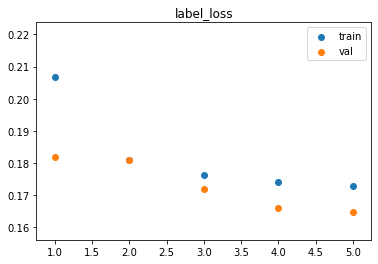

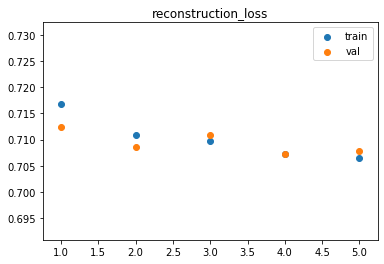

In [94]:
def plot_train_vs_val(history, epochs, loss_name):
    plt.figure()
    plt.scatter(range(1,epochs+1),history.history[loss_name], label = "train")
    plt.scatter(range(1,epochs+1),history.history["val_"+loss_name], label = "val")
    plt.legend(loc="upper right")
    plt.title(loss_name)
    plt.show()
#plot_train_vs_val(history, EPOCHS, "loss")
plot_train_vs_val(history, EPOCHS, "label_loss")
plot_train_vs_val(history, EPOCHS, "reconstruction_loss")


r51_pT_o0_bn2_None_tanh_tanh_4*(4+4|4)_e5_1.0:1.0_otT
Generated


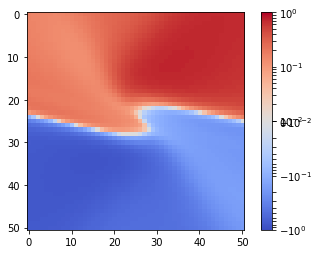

Given_train


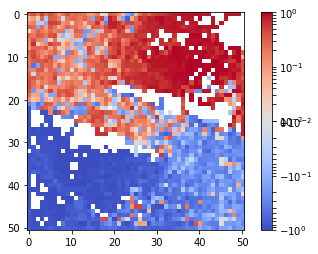

In [95]:
RESOLUTION = 51
STAMP = "r" + str(RESOLUTION) + "_p" + str(PROGRESS_LABEL)[0] + "_o" + str(OFFSET) \
    + "_bn" + str(BOTTLENECK_SIZE) \
    + "_" + str(ENCODER_ACT_FUNC) + "_" + str(DECODER_1_ACT_FUNC) \
    + "_" + str(DECODER_2_ACT_FUNC) + "_" + str(NODE_MULT) + "*(" \
    + str(ENCODER_HIDDEN) + "+" + str(DECODER_1_HIDDEN) + "|" + str(DECODER_2_HIDDEN) + ")_e" + str(EPOCHS) + "_" \
    + str(LABEL_LOSS_WEIGHT) + ":" \
    + str(RECONSTRUCTION_LOSS_WEIGHT) \
    + "_ot" + str(ONLY_TRANSITION)[0]
print(STAMP)

def plot_one_map(label_map, mode, stamp):
    plt.figure()
    plt.imshow(np.transpose(label_map[0])[::-1], \
            cmap='coolwarm', \
            interpolation='nearest', norm=mpl.colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                  vmin=-1.0, vmax=1.0))
    plt.colorbar()
    plt.savefig("{}_{}.png".format(stamp, mode)) 
    plt.show()

print("Generated")
label_map = map_generated(autoencoder_1, "snapshot", "label", \
        np.linspace(min_values[0], max_values[0], RESOLUTION), \
        np.linspace(min_values[1], max_values[1], RESOLUTION), \
        0, 0, 1)
plot_one_map(label_map, "gen", STAMP)

print("Given_train")
label_map = map_given_labels(train_past_snapshot_list, \
    train_snapshot_label_list, \
    np.linspace(min_values[0], max_values[0], RESOLUTION), \
    np.linspace(min_values[1], max_values[1], RESOLUTION), \
    0, 1)
plot_one_map(label_map, "giv", STAMP)

#print("Given_test")
#label_map = map_given_labels(test_past_snapshot_list, \
#    test_snapshot_label_list, \
#    np.linspace(min_values[0], max_values[0], RESOLUTION), \
#    np.linspace(min_values[1], max_values[1], RESOLUTION), \
#    0, 1)
#plot_one_map(label_map, "given")

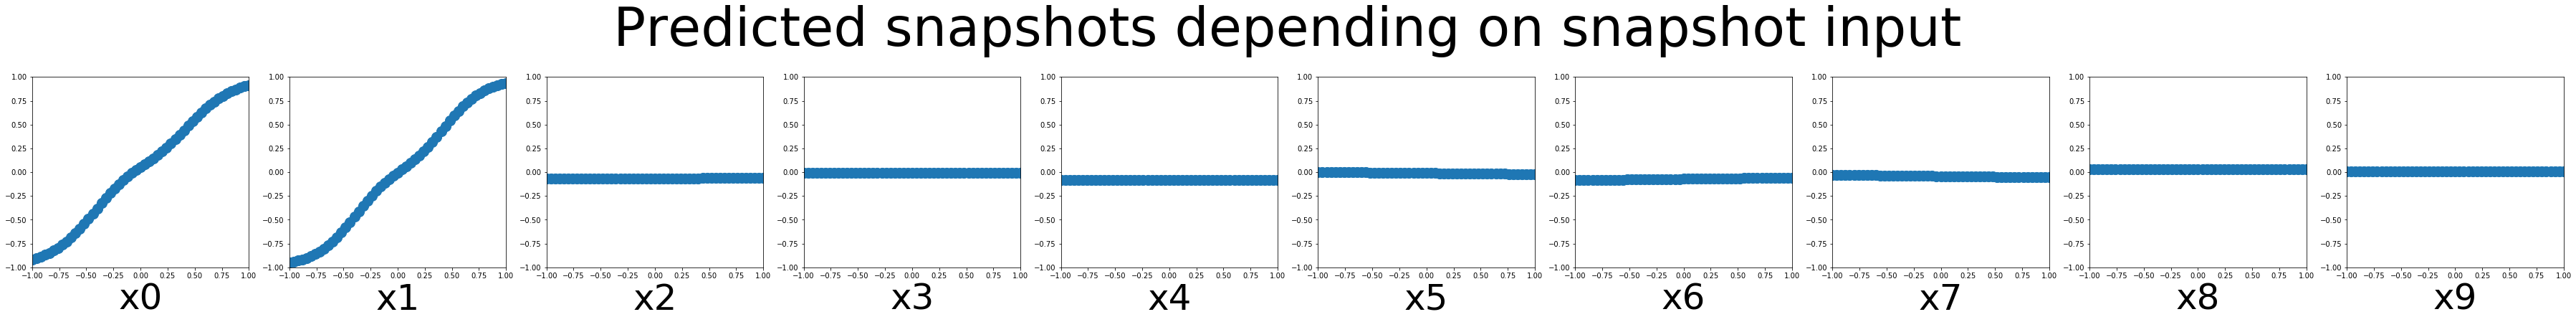

In [96]:
FIG_SIZE = 50
make_scatter_figure(autoencoder_2, -1, 1, RESOLUTION, DIMENSIONS, 0, STAMP)
#make_scatter_figure(autoencoder_2, -1, 1, RESOLUTION, DIMENSIONS, -0.5)
#make_scatter_figure(autoencoder_2, -1, 1, RESOLUTION, DIMENSIONS, 0.5)

Caution!
Correlation between input data can affect the reliability of the importance measure.
Strong correlations of more than 0.1 were found between 1 pair(s) of input variables:
	1,0: 0.285
Additionally, weak correlations of more than 0.01 were found between 0 pair(s) of input variables:
	
Mode: Mean
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 9.
Mode: HIPR
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 9.
Mode: Shuffle
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Pert

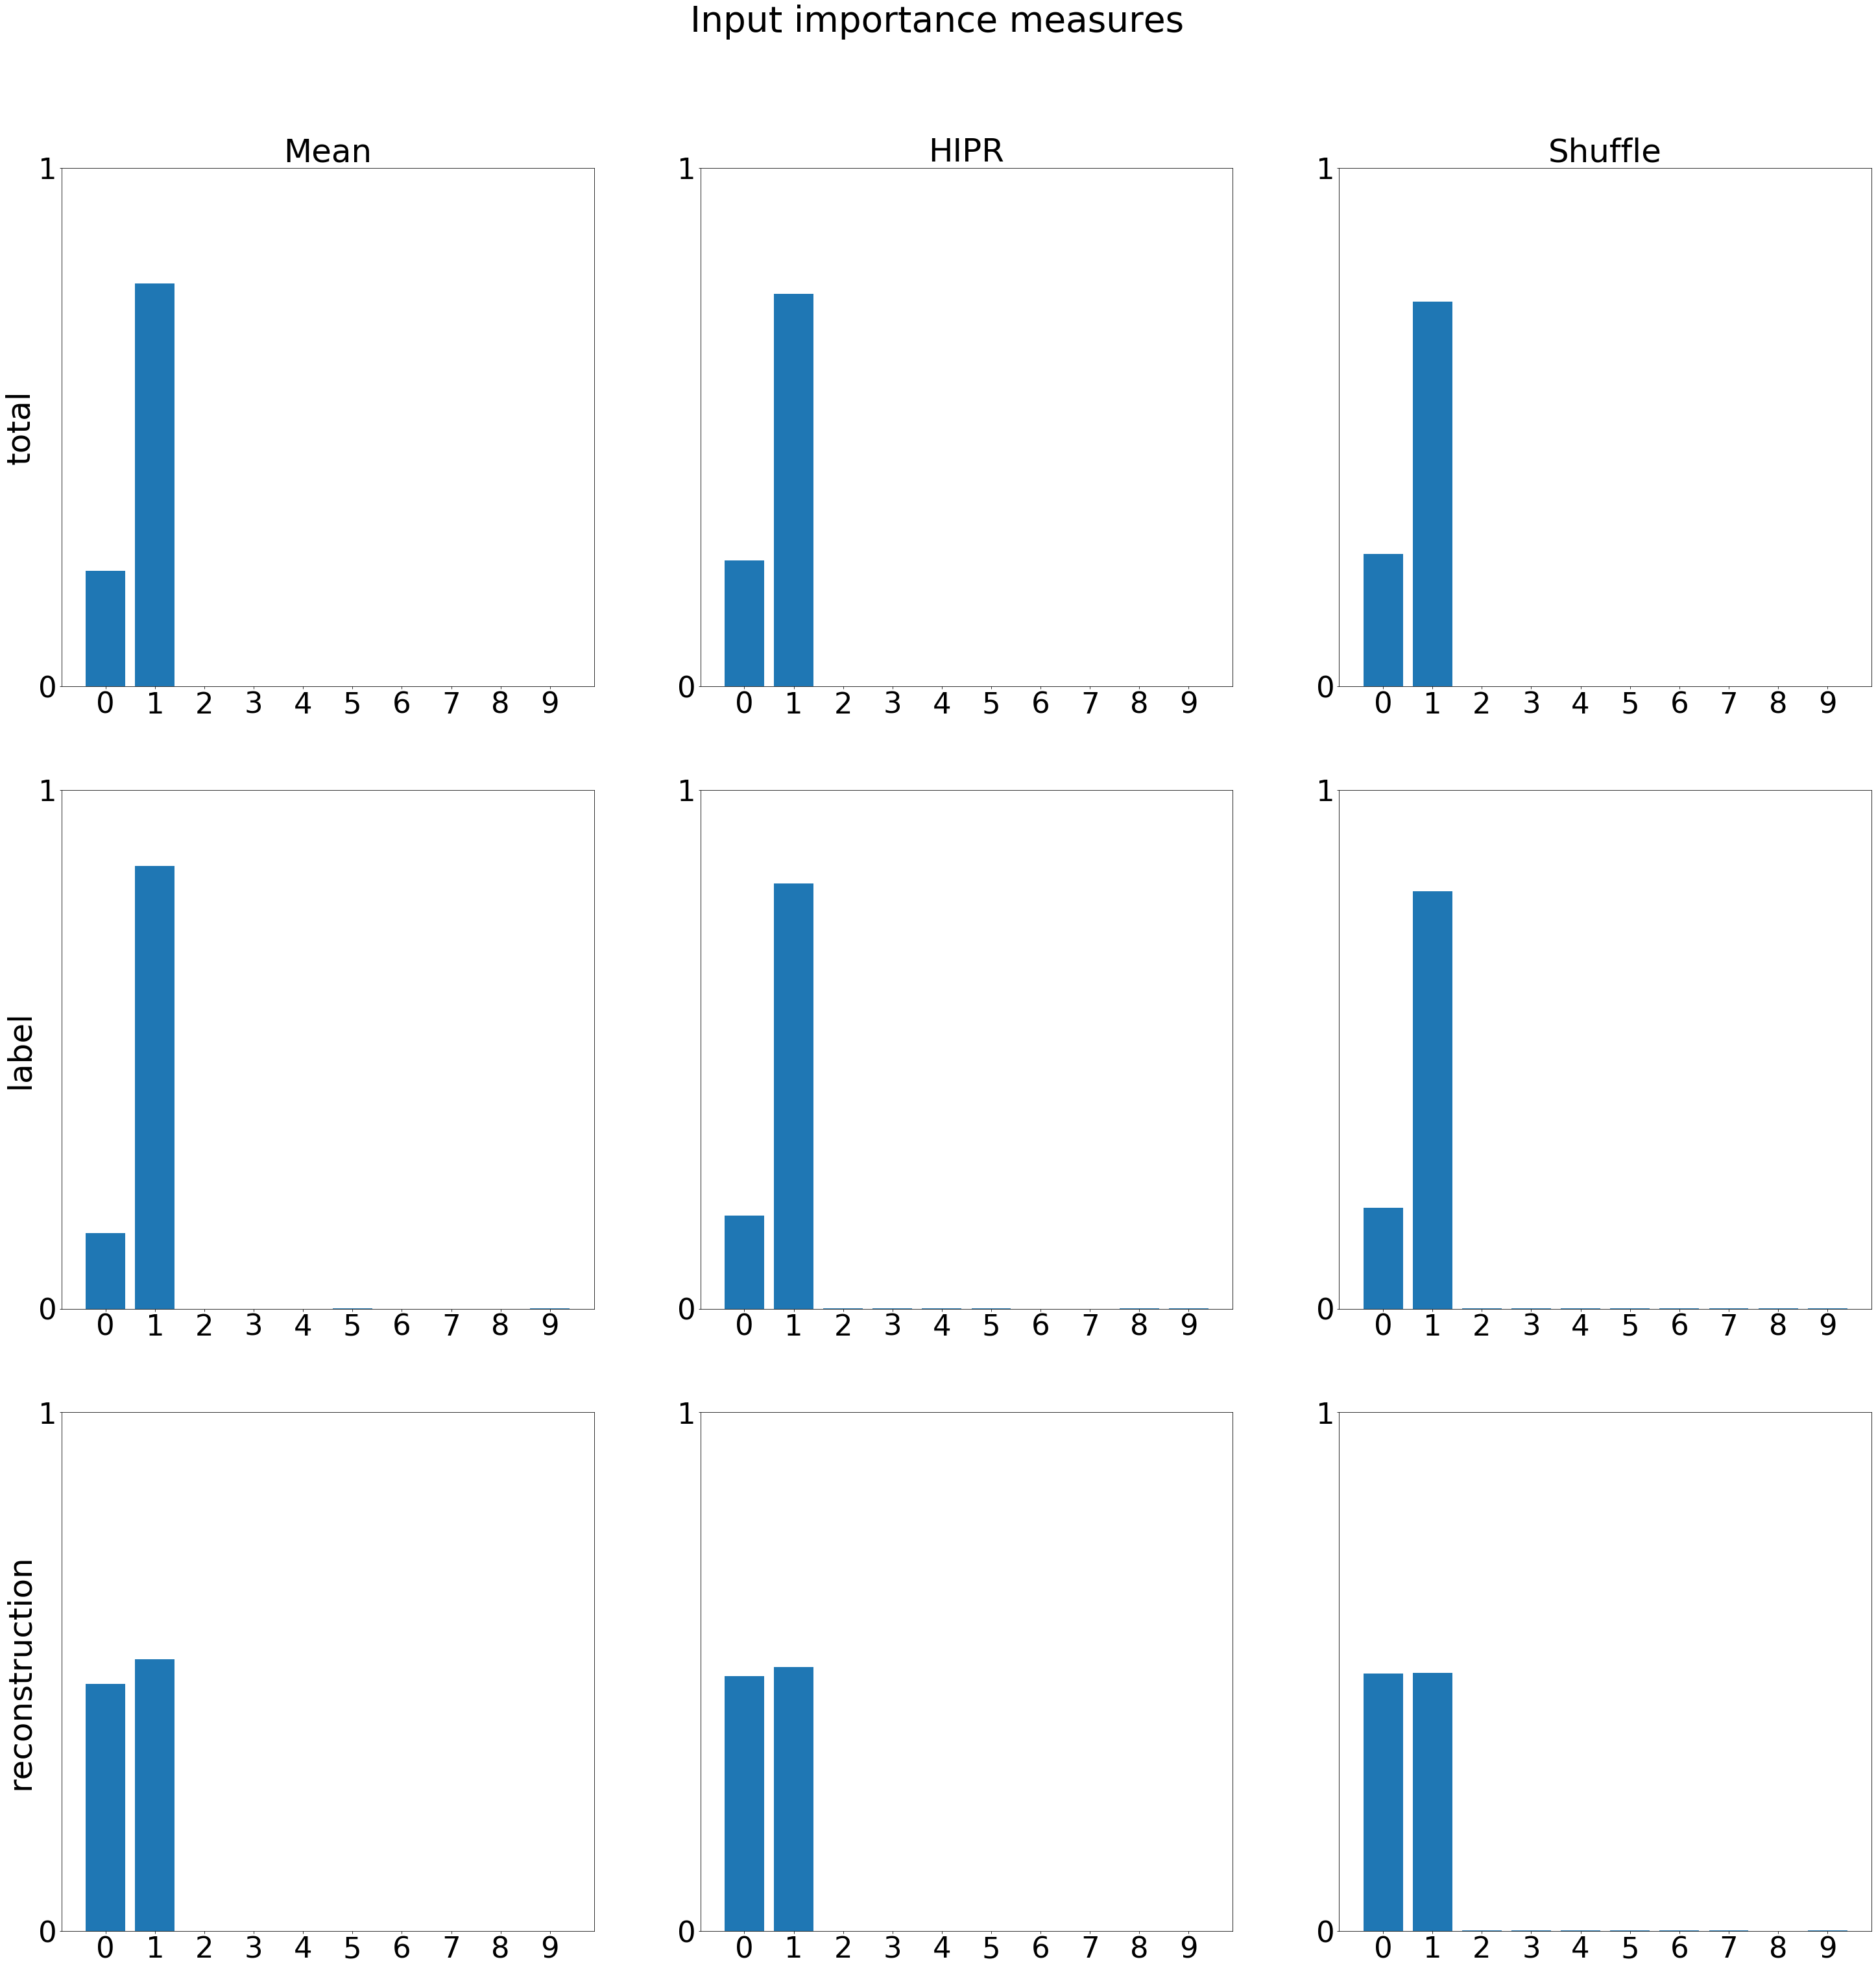

In [27]:
strong_correlated_input_list, weak_correlated_input_list = measure_correlation(test_past_snapshot_list)

#mode_list = [["Perturb", 0.5],["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]
mode_list = [["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]

plot_all_input_importance(autoencoder, mode_list, test_ds_batch, test_past_snapshot_list, \
            test_snapshot_label_list, test_snapshot_list, range(10), 1)


0 1
0


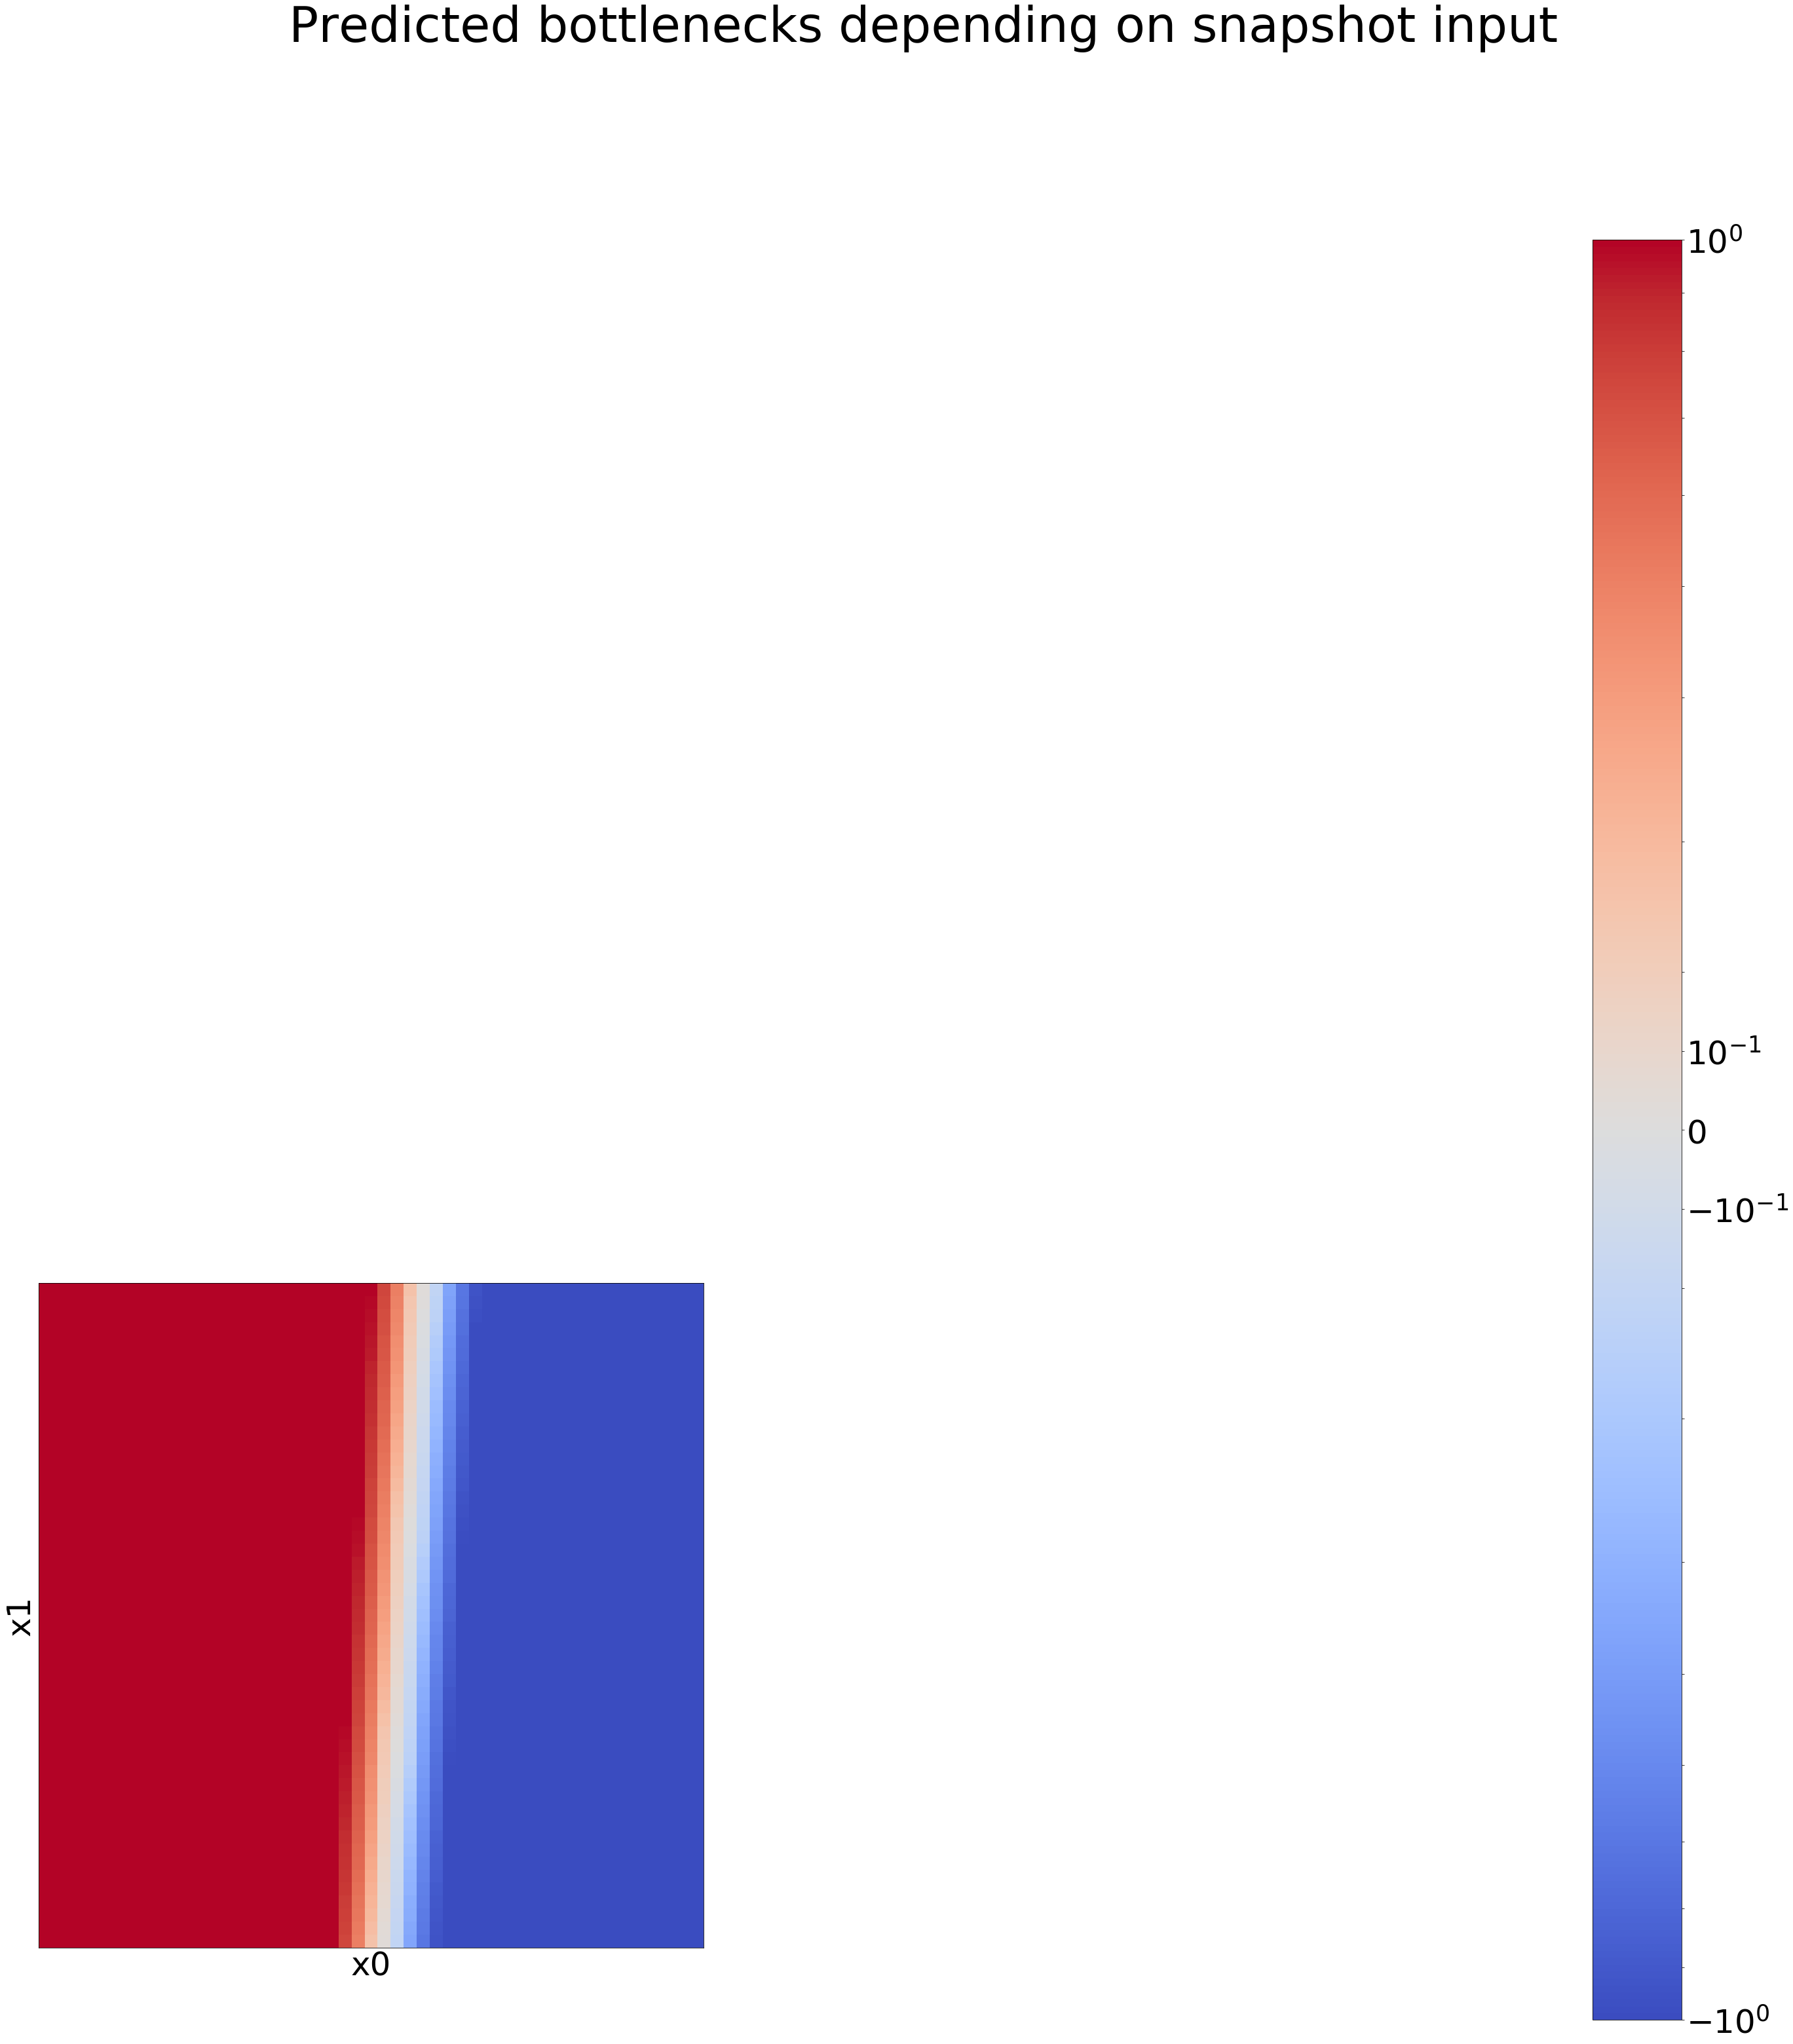

1


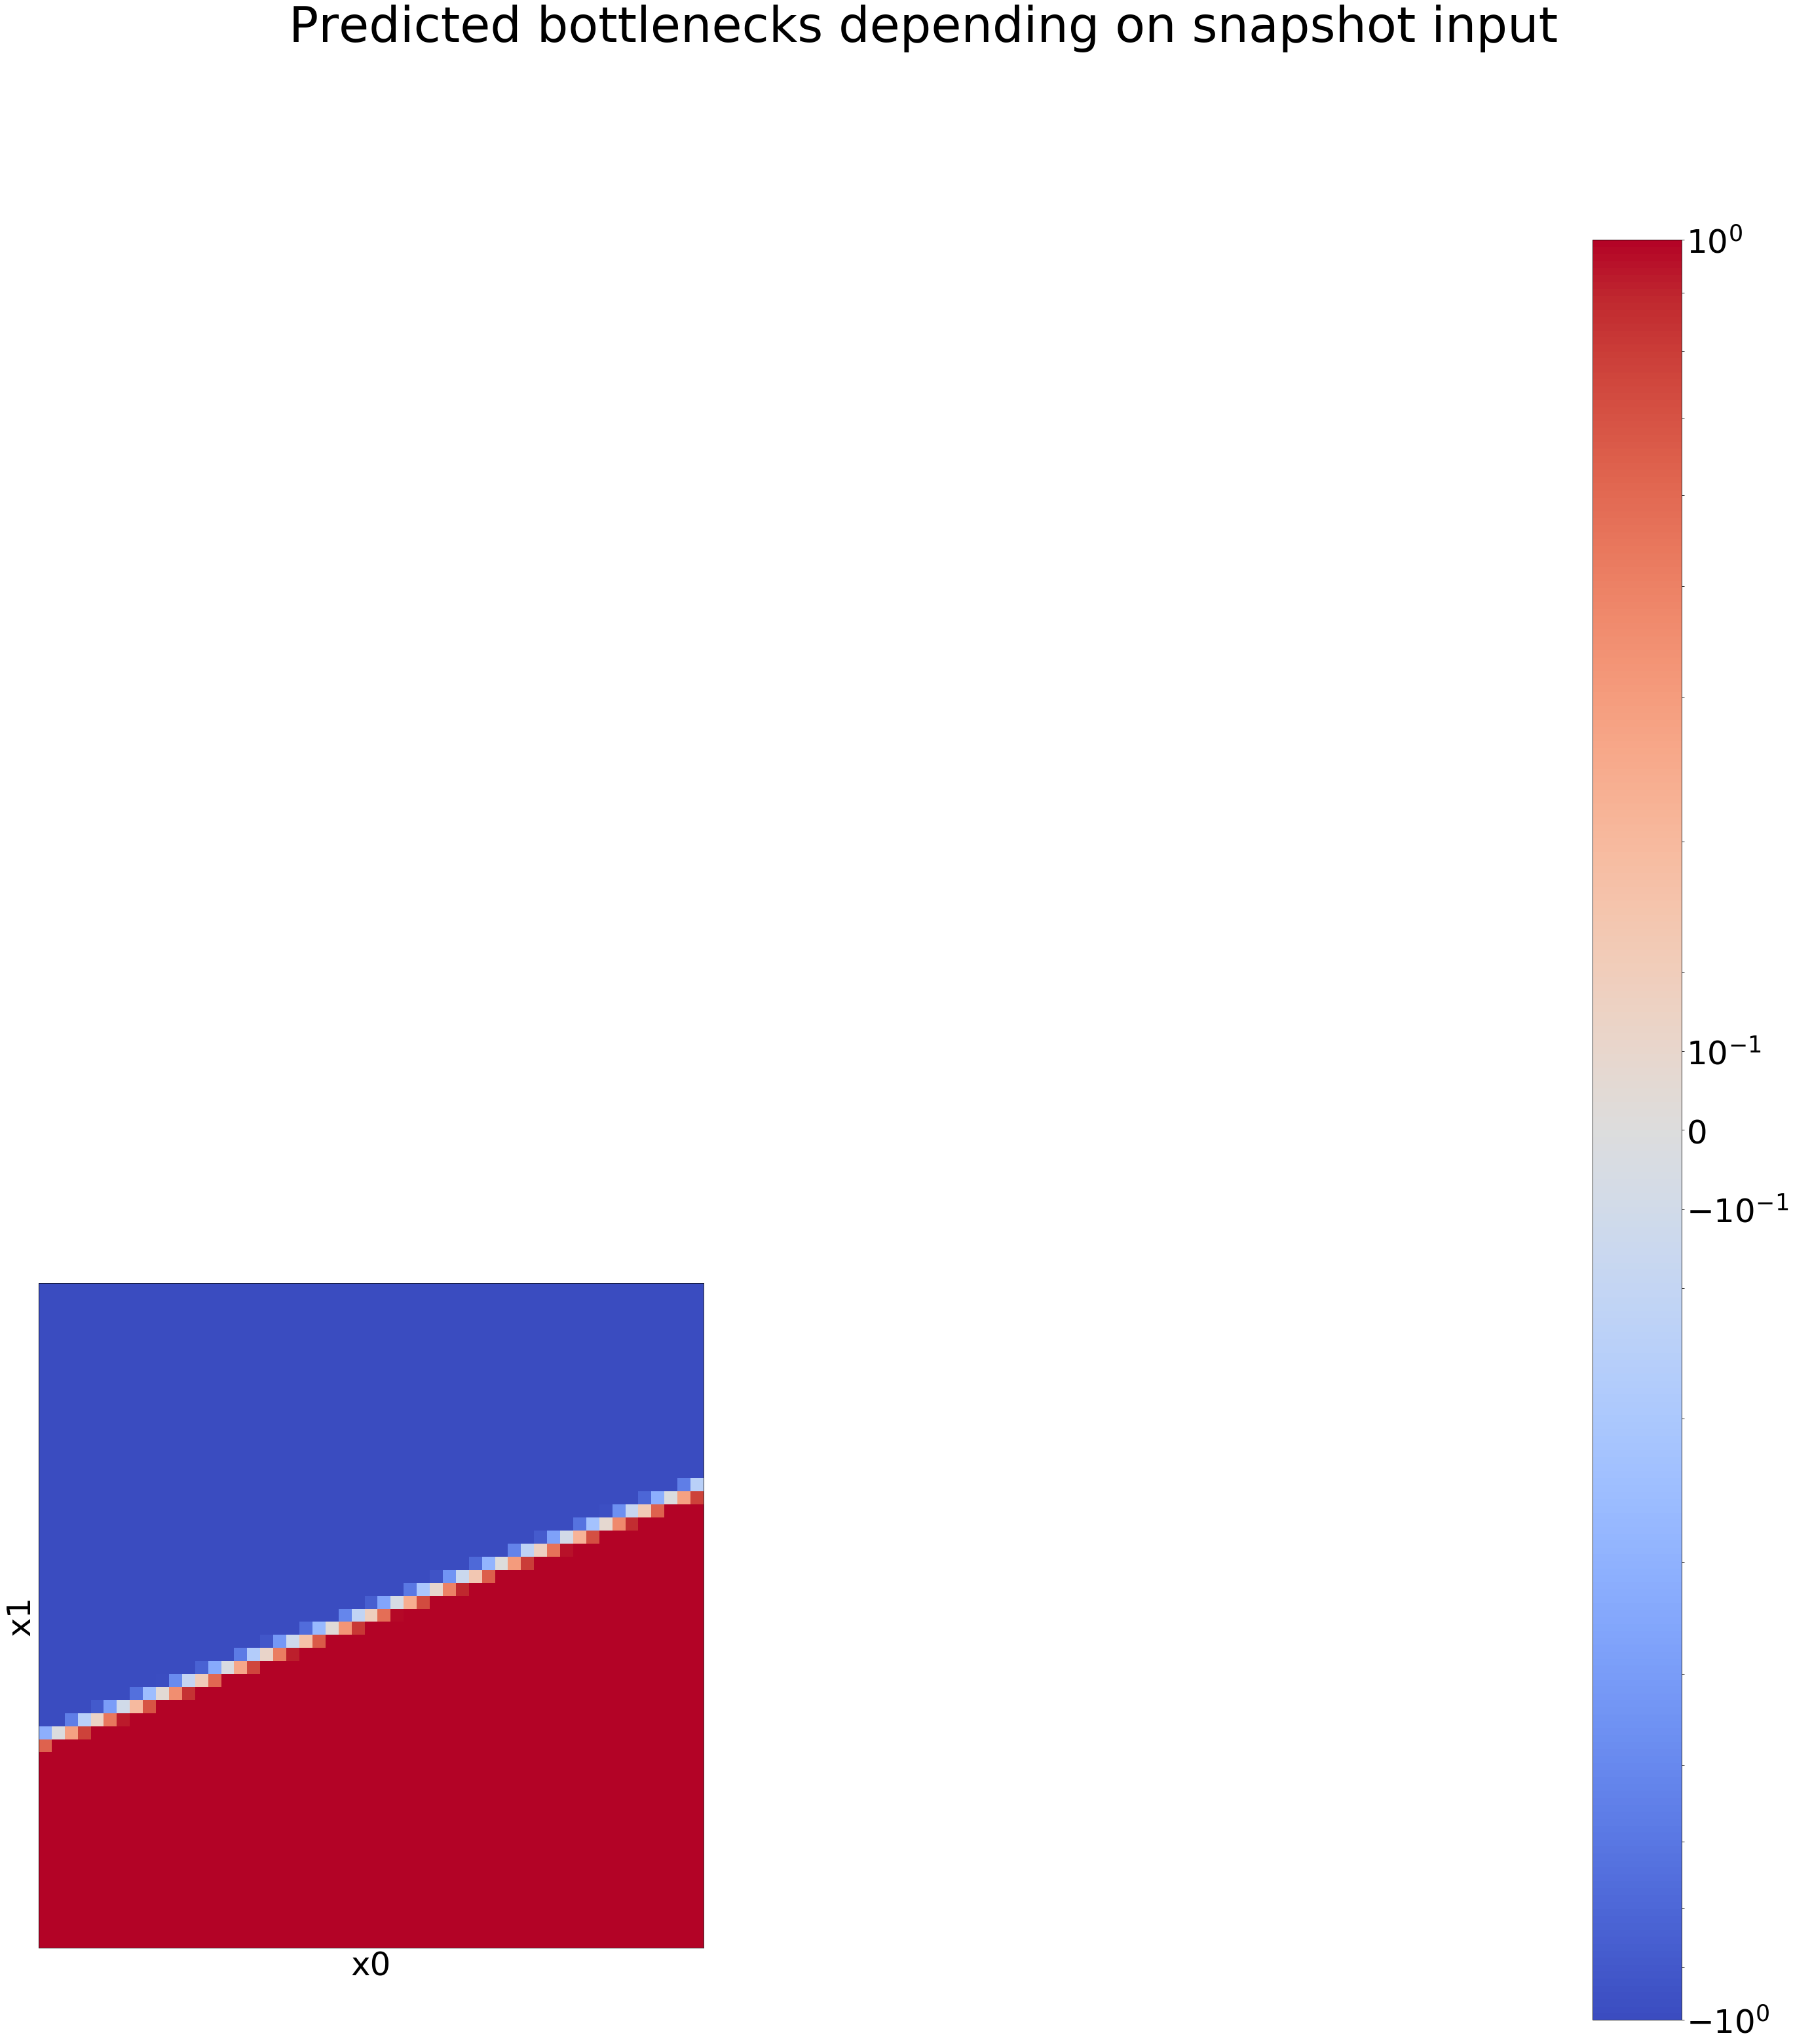

0 1
0


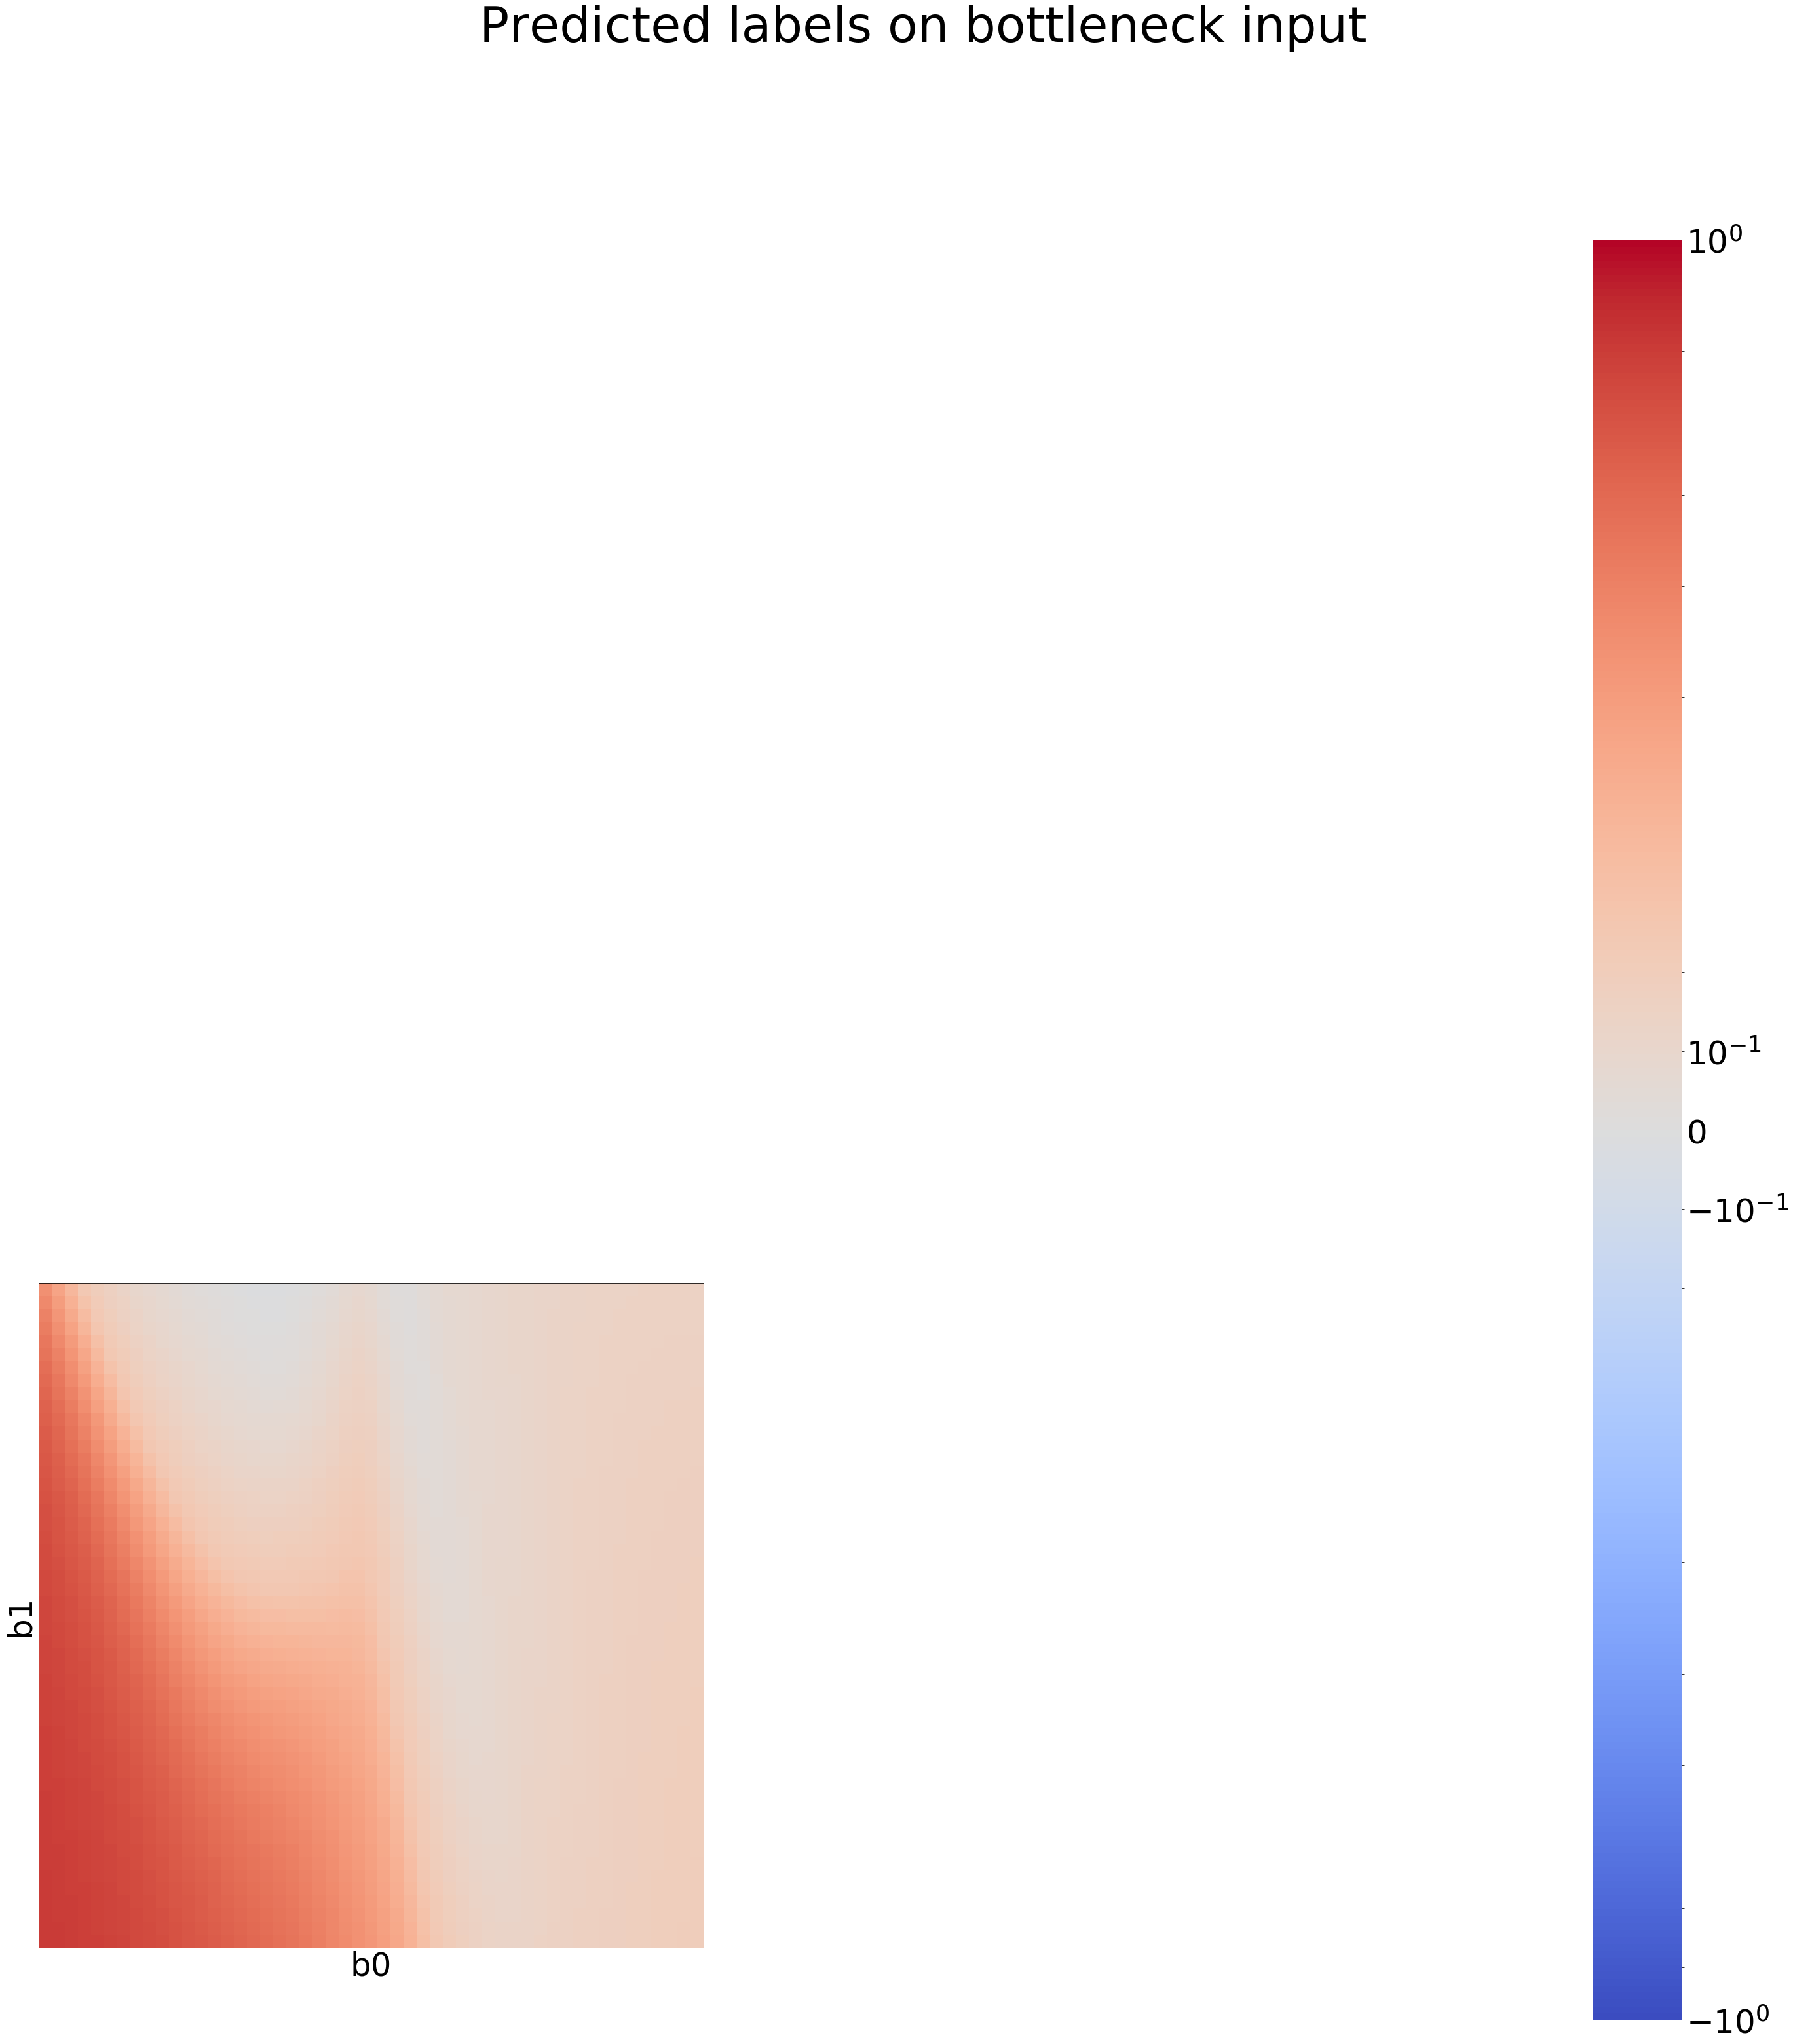

In [28]:

#meta_label_map_1 = make_label_map_figure(mode = "given", mode_var = [test_past_snapshot_list, test_snapshot_label_list], \
#        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
#        vmin = 0, vmax = 1)

#meta_label_map_2 = make_label_map_figure(mode = "generated", mode_var = [autoencoder_1, 0], \
#        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
#        vmin = 0, vmax = 1)

#meta_label_map_3 = make_label_map_figure(mode = "generated", mode_var = [autoencoder_2, 0], \
#        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
#        vmin = -1, vmax = 1)

meta_label_map_4 = make_label_map_figure(mode = "generated", mode_var = [encoder, 0], \
        resolution = RESOLUTION, i_range = 2, j_range = 2, \
        vmin = -1, vmax = 1)

meta_label_map_5 = make_label_map_figure(mode = "generated", mode_var = [decoder_1, 0], \
        resolution = RESOLUTION, i_range = BOTTLENECK_SIZE, j_range = BOTTLENECK_SIZE, \
        vmin = 0, vmax = 1)

#meta_label_map_6 = make_label_map_figure(mode = "generated", mode_var = [decoder_2, 0], \
#        resolution = RESOLUTION, i_range = BOTTLENECK_SIZE, j_range = BOTTLENECK_SIZE, \
#        vmin = -1, vmax = 1)

In [ ]:
"""
toy_ds = test_ds
toy_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME:[[0,0], [1,2], [3,3]]},{"b":[1,2,3]},{"c":[1,2,3]})).shuffle(4)

filtered_toy_ds = test_ds.filter(lambda x,y,z: tf.reduce_all([x[INPUT_NAME][i] < upper_bound[i] \
                                                        and x[INPUT_NAME][i] > lower_bound[i] \
                                                        for i in range(len(x[INPUT_NAME]))]))
#filtered_toy_ds = toy_ds.filter(lambda x,y,z: x["a"][0] < 3) 
#filtered_toy_ds = toy_ds.filter(lambda x,y,z: all([x["a"][i] < 2 for i in range(2)]))

show_batch(filtered_toy_ds)"""

In [19]:
"""Filter outliers"""

"""Problem: If done for test set this way there will simply be no prediction"""
# calculates the lower and upper bound for the normalized dataset according to the OUTLIER_CUTOFF
lower_bound = np.percentile(train_past_snapshot_list, 100*OUTLIER_CUTOFF, axis = 0)
upper_bound = np.percentile(train_past_snapshot_list, 100*(1-OUTLIER_CUTOFF), axis = 0)

# uses dataset.filter to filter out all snapshots that have at least one value outside of the bounds
# the lambda function returns True or False for each instance of the dataset depending on whether 
#the conditions are met
# tf.reduce_all returns True if all values in the list composed by list comprehension are True
# the list comprehension generates a list of True and False values for each dimension of the input
#and whether the corresponding value lies within the bounds of this dimension
test_ds = test_ds.filter(lambda inputs,labels,weights: tf.reduce_all([inputs[INPUT_NAME][i] < upper_bound[i] \
                                                        and inputs[INPUT_NAME][i] > lower_bound[i] \
                                                        for i in range(len(inputs[INPUT_NAME]))]))
train_ds = train_ds.filter(lambda inputs,labels,weights: tf.reduce_all([inputs[INPUT_NAME][i] < upper_bound[i] \
                                                        and inputs[INPUT_NAME][i] > lower_bound[i] \
                                                        for i in range(len(inputs[INPUT_NAME]))]))

In [ ]:
#perturbed_loss_list= input_importance("Perturb", 0.5, autoencoder, test_norm_ds_batch, test_past_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(perturbed_loss_list,1,"Perturb_0.5")
#mean_loss_list = input_importance("Mean", None, autoencoder, test_norm_ds_batch, test_past_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(mean_loss_list,1,"Mean")
#hipr_loss_list = input_importance("HIPR", [-0.9,0.9], autoencoder, test_norm_ds_batch, test_past_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(hipr_loss_list,1,"HIPR_range[-0.9,0.9]")
#shuffle_loss_list = input_importance("Shuffle", None, autoencoder, test_norm_ds_batch, test_past_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(shuffle_loss_list,1,"Shuffle")



In [46]:
# accessing the output of all layers
features_list = [layer.output for layer in encoder.layers]
feat_extraction_model = keras.Model(inputs=encoder.input, outputs=features_list[-1])
img = np.random.random((1,10)).astype('float32')
print(encoder(img).numpy())
extracted_features = feat_extraction_model(img)
print(extracted_features.numpy())

[[ 0.172 -0.771]]
[[ 0.172 -0.771]]
